In [25]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import altair
import seaborn
RANDOM_SEED = 511
rng = np.random.default_rng(RANDOM_SEED)
seaborn.set_theme(style="darkgrid")
altair.renderers.enable('mimetype')

db_url: str = os.getenv('DB_URL')

In [26]:
%load_ext autoreload
%autoreload 2
from lib import wrap_labels, adjust_pairplot_axes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# OTP Overconcentration

The data below is essentially the same as the GHC website's "oversaturation data", except:
* I don't drop patient zip codes outside NYC, which I believe fell through a join somewhere


My goal is to make the "OTP programs are overconcentrated in Harlem" in a bunch of ways:
* Harlem Admission % ~ Harlem Capacity % > Harlem Patient % > Harlem population %
    * Compare with other areas of the city
* Compare fractions of admissions residing outside across different districts
    * Across programs?
* Compare with OD rates?

## By District (no patient residences, but I currently have populations)

In [27]:
sql = """
select
    borough_district_code,
    district_population AS "Population", 
    CASE WHEN is_harlem THEN 'Harlem' ELSE 'Rest of NYC' END AS is_harlem,
    total_admissions_3_2017 AS "Estimated OTP Admissions (2017)",
    total_admissions_3_2019 AS "Estimated OTP Admissions (2019)",
    otp_capacity AS "Reported OTP Capacity (2019)",
    avg_daily_enrollment_2019 AS "Reported Daily Avg OTP Enrollment (2019)"
from district_otp_analysis
"""
district_df = pd.read_sql(sql, con=db_url)
district_df = district_df.fillna(0)

for c in [
    'borough_district_code',
    'is_harlem'
]:
    district_df[c] = pd.Categorical(district_df[c])

district_df['Estimated Fraction of OTP Admissions (2019)'] = district_df["Estimated OTP Admissions (2019)"] \
    / district_df["Estimated OTP Admissions (2019)"].sum()
district_df['Fraction of Population'] = district_df["Population"] \
    / district_df["Population"].sum()

district_df = district_df.set_index('borough_district_code')
district_df.head(3).T


borough_district_code,501,309,308
Population,189663,102000,108259
is_harlem,Rest of NYC,Rest of NYC,Rest of NYC
Estimated OTP Admissions (2017),34.0,205.0,280.0
Estimated OTP Admissions (2019),37.0,198.0,210.0
Reported OTP Capacity (2019),220.0,750.0,750.0
Reported Daily Avg OTP Enrollment (2019),218.0,517.0,661.0
Estimated Fraction of OTP Admissions (2019),0.002892,0.015474,0.016411
Fraction of Population,0.039841,0.021426,0.022741


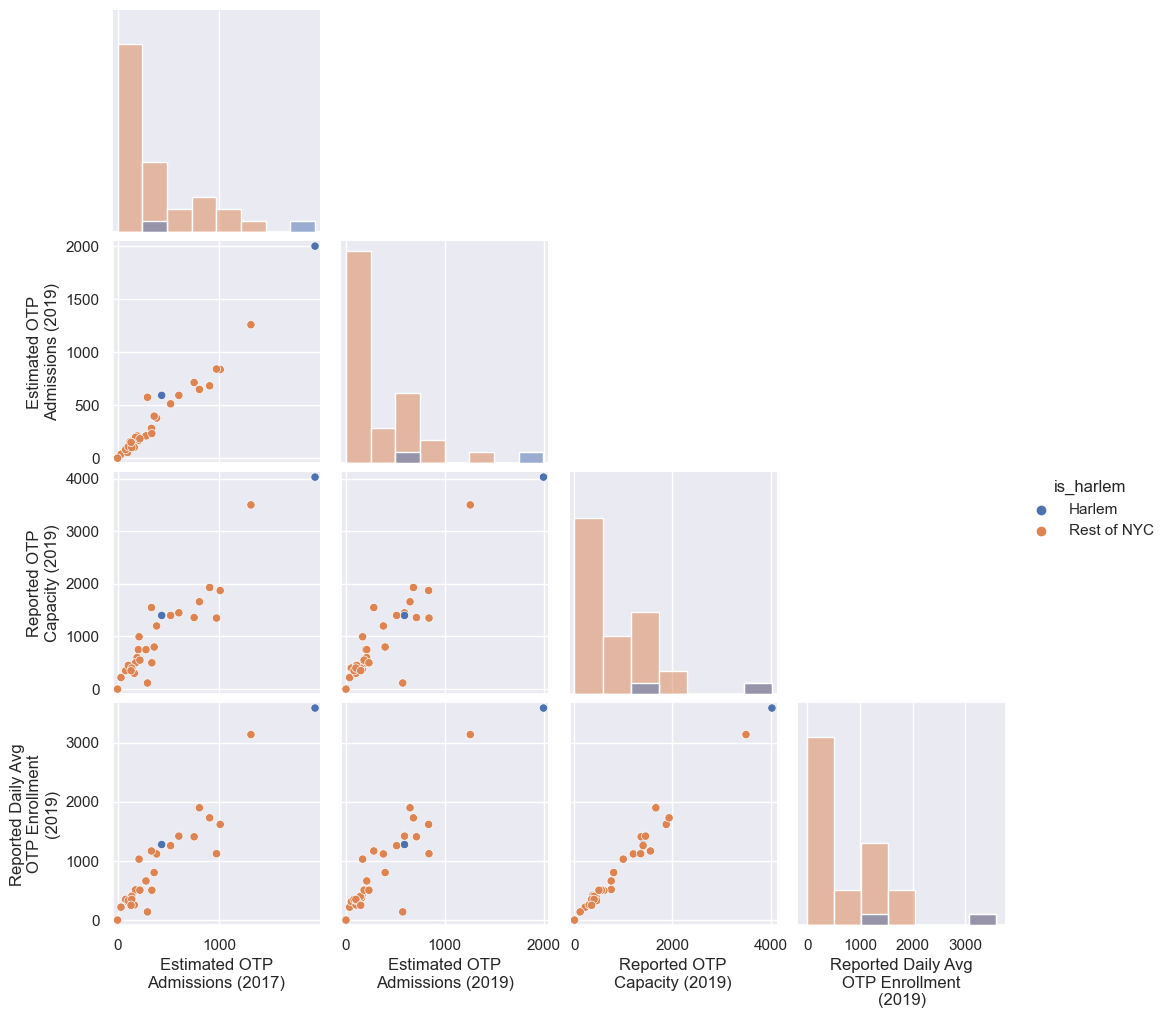

In [28]:
measures = [
    'Estimated OTP Admissions (2017)',
    'Estimated OTP Admissions (2019)',
    'Reported OTP Capacity (2019)',
    'Reported Daily Avg OTP Enrollment (2019)'
]

p = seaborn.pairplot(
    district_df[measures + ['is_harlem']], 
    hue='is_harlem',
    diag_kind="hist", 
    corner=True
);

adjust_pairplot_axes(district_df, measures, p)

,Population,Estimated OTP Admissions (2019),Reported OTP Capacity (2019),Reported Daily Avg OTP Enrollment (2019)
is_harlem,,,,
Harlem,0.05382,0.202485,0.169879,0.166718
Rest of NYC,0.94618,0.797515,0.830121,0.833282


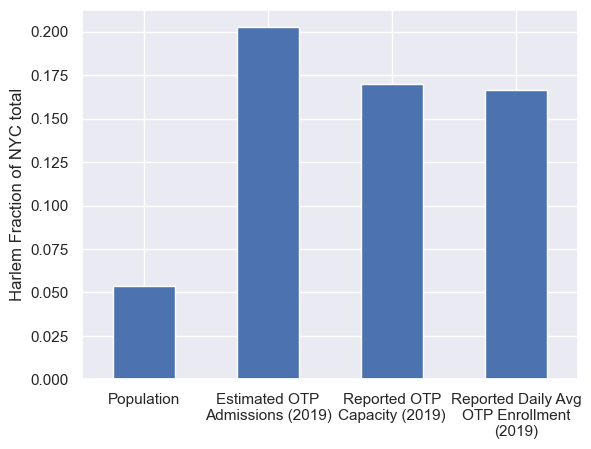

In [29]:
district_metrics_by_harlem = (
    district_df[[
        'Population',
        'Estimated OTP Admissions (2019)',
        'Reported OTP Capacity (2019)',
        'Reported Daily Avg OTP Enrollment (2019)',
    ]]
    .groupby(district_df['is_harlem'])
    .sum()
)
district_metrics_by_harlem = district_metrics_by_harlem / district_metrics_by_harlem.sum()
ax = district_metrics_by_harlem.loc['Harlem'].plot(
    kind='bar',
    ylabel='Harlem Fraction of NYC total'
);
plt.xticks(rotation=0)
wrap_labels(ax, 20)
district_metrics_by_harlem

,Population,Estimated OTP Admissions (2019),Reported OTP Capacity (2019),Reported Daily Avg OTP Enrollment (2019)
borough_district_code,,,,
111,0.100255,0.246395,0.199931,0.193803
201,0.080453,0.155060,0.173680,0.169578
206,0.071116,0.079872,0.082374,0.102633
106,0.124044,0.084063,0.095772,0.093441
103,0.130044,0.103044,0.092944,0.087438
306,0.090819,0.072969,0.071953,0.076732
205,0.105686,0.087884,0.067487,0.076137
110,0.103977,0.072969,0.069472,0.069053
102,0.073690,0.063109,0.069472,0.068026


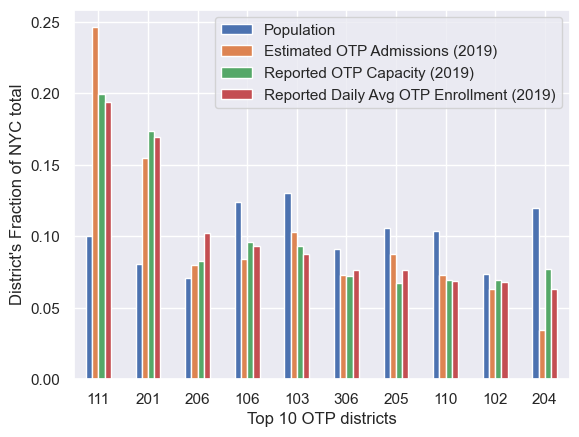

In [30]:
district_metrics_by_district = (
    district_df[[
        'Population',
        'Estimated OTP Admissions (2019)',
        'Reported OTP Capacity (2019)',
        'Reported Daily Avg OTP Enrollment (2019)',
    ]]
    .sort_values("Reported Daily Avg OTP Enrollment (2019)", ascending=False)
    .head(10)
)
district_metrics_by_district = district_metrics_by_district / district_metrics_by_district.sum()
district_metrics_by_district.plot(
    kind='bar',
    ylabel="District's Fraction of NYC total",
    xlabel='Top 10 OTP districts'
);
plt.xticks(rotation=0)
district_metrics_by_district